# What do I want?

Previously in `HSC_COSMOS_filtering.ipynb` I tested out some basic classifiers to get a smaller sample set, while still keeping completeness high.  I tested two basic classifiers: a RandomForest classifier and a Logistic Regression classifier.

For my training data, I started by getting objects and labels from COSMOS. For input features, I then matched those COSMOS galaxies to their nearest HSC counterpart. I then used HSC i-band magnitude, along with HSC g-r, r-i, i-z, z-y colors.

Choosing some arbitrary thresholds, I got similar results for the Random Forest and the Logistic Regression classifiers. In this notebook I'll look at the full ROC curves for both classifiers, in hopes of better understanding my results.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.colors as colors

import seaborn as sns
sns.set(context="poster", style="ticks", font_scale=1.4)

import numpy as np
import pandas as pd

import astropy

import datasets
from matching import Matches

In [2]:
COSMOS = datasets.COSMOS("COSMOS_reference.sqlite")

In [3]:
HSC = datasets.HSC("HSC_COSMOS_median_forced.sqlite3")

In [4]:
COSMOS.df.shape

(518331, 14)

In [5]:
HSC.df.shape

(928534, 20)

In [6]:
downsample_factor_COSMOS = 1
mask_COSMOS_downsample = (COSMOS.df.index % downsample_factor_COSMOS == 0)

downsample_factor_HSC = 1
mask_HSC_downsample = (HSC.df.index % downsample_factor_HSC == 0)


matches = Matches(COSMOS,
                  HSC,
                  mask_catalog_1=mask_COSMOS_downsample,
                  mask_catalog_2=mask_HSC_downsample,
                 )

In [7]:
low_z = (matches.catalog_1.df[matches.mask_catalog_1].photo_z < .15)
low_mass = (matches.catalog_1.df[matches.mask_catalog_1].mass_med < 9)

# Create classification labels

Class A: matched **and** (low redshift + low mass)

Class B: matched **but not** (low redshift + low mass)

In [8]:
class_a = matches.mask_match & (low_z & low_mass)
class_b = matches.mask_match & ~(low_z & low_mass)

In [9]:
idxs = matches.idx[class_a.values]

In [10]:
class_a.mean()

0.016740268284165909

In [11]:
class_b.mean()

0.76481630463931349

In [12]:
class_a.sum() / (class_a.sum() + class_b.sum())

0.021419138248108514

In [13]:
class_b.sum() / (class_a.sum() + class_b.sum())

0.97858086175189152

In [14]:
matches.catalog_2.df["low_z_low_mass"] = False
# only change the flag if the object has been matched to, and if it is in class_a
matches.catalog_2.df.loc[matches.catalog_2.df.index[matches.mask_catalog_2][idxs],
                         ["low_z_low_mass"]] = True

In [15]:
# this is different from `class_a.mean()`
# because COSMOS galaxies (which `class_a` referred to)
# don't have a 1-to-1 map to HSC galaxies, even if they map
# (we expect ~2 HSC galaxies to map to a given COSMOS galaxy, on average)

# why this is lower, rather than higher, I don't know
matches.catalog_2.df["low_z_low_mass"].mean()

0.0093437612408377082

In [16]:
matches.catalog_2.df.low_z_low_mass.describe()

count     928534
unique         2
top        False
freq      919858
Name: low_z_low_mass, dtype: object

# Create a dataframe of just the matched galaxies

In [17]:
matched_hsc = matches.catalog_2.df[matches.mask_catalog_2].iloc[matches.idx[matches.mask_match]]

In [18]:
matched_hsc.describe()

,ra,dec,gcmodel_flux,gcmodel_flux_err,rcmodel_flux,rcmodel_flux_err,icmodel_flux,icmodel_flux_err,zcmodel_flux,zcmodel_flux_err,ycmodel_flux,ycmodel_flux_err
count,405105.000000,405105.000000,3.807070e+05,3.797180e+05,3.928980e+05,3.927810e+05,4.000690e+05,3.999100e+05,4.012240e+05,4.009350e+05,3.973020e+05,3.937970e+05
mean,150.125195,2.232177,5.425872e-30,2.441965e-31,1.029383e-29,2.389800e-31,1.654315e-29,4.080820e-31,2.199698e-29,5.481674e-31,2.490816e-29,1.632571e-30
std,0.348160,0.332707,3.119192e-29,7.493017e-32,7.011325e-29,7.309994e-30,1.066369e-28,1.406897e-31,1.414026e-28,2.049140e-31,1.637729e-28,5.286459e-31
min,149.504140,1.614650,-3.166004e-30,1.418267e-31,-1.065718e-26,1.085367e-31,-2.291145e-29,2.243794e-31,-1.310448e-29,3.025446e-31,-1.932652e-28,9.309609e-31
25%,149.834656,1.959245,9.857951e-31,1.992327e-31,1.456064e-30,1.718896e-31,1.963559e-30,3.232955e-31,2.287109e-30,4.324975e-31,2.040853e-30,1.329182e-30
50%,150.124488,2.227293,1.830453e-30,2.313752e-31,2.553482e-30,2.125267e-31,3.544400e-30,3.851301e-31,4.277338e-30,5.169591e-31,4.762685e-30,1.552165e-30
75%,150.408445,2.518028,3.803438e-30,2.696399e-31,5.449333e-30,2.561621e-31,8.000151e-30,4.524762e-31,1.040165e-29,6.113587e-31,1.168667e-29,1.814321e-30
max,150.786531,2.814174,5.125727e-27,8.857377e-30,1.073492e-26,4.581177e-27,1.528213e-26,1.509215e-29,1.988747e-26,2.604209e-29,2.235993e-26,8.761765e-29


In [19]:
matched_hsc.head()

,ra,dec,detect_is_patch_inner,detect_is_tract_inner,detect_is_primary,gcmodel_flux,gcmodel_flux_err,gcmodel_flux_flags,rcmodel_flux,rcmodel_flux_err,...,icmodel_flux,icmodel_flux_err,icmodel_flux_flags,zcmodel_flux,zcmodel_flux_err,zcmodel_flux_flags,ycmodel_flux,ycmodel_flux_err,ycmodel_flux_flags,low_z_low_mass
object_id,,,,,,,,,,,,,,,,,,,,,
43158996781122114,149.749414,1.618092,True,True,True,7.760156e-29,4.177573e-31,False,NaN,NaN,...,6.303301e-28,1.415450e-30,False,8.553727e-28,1.656983e-30,False,1.004911e-27,3.037335e-30,False,False
43158447025298860,150.388341,1.614668,True,True,True,5.800470e-31,2.102453e-31,False,1.333949e-30,1.788977e-31,...,2.348454e-30,5.105159e-31,False,1.967417e-30,4.042161e-31,False,4.328439e-31,1.392682e-30,False,False
43158447025298862,150.402906,1.614679,True,True,True,8.775548e-31,2.110055e-31,False,1.553413e-30,1.647729e-31,...,1.666095e-30,3.575105e-31,False,1.105359e-30,4.225365e-31,False,2.347631e-30,1.432457e-30,False,False
43158584464246387,150.295027,1.614650,True,True,True,1.312252e-30,3.044583e-31,False,2.617042e-30,2.799434e-31,...,3.989077e-30,5.396980e-31,False,4.817932e-30,7.052368e-31,False,3.960493e-30,2.091224e-30,False,False
43158584464253383,150.239846,1.614712,True,True,True,8.597155e-31,1.999684e-31,False,1.424355e-30,1.705562e-31,...,1.373718e-30,3.604136e-31,False,2.152825e-30,5.385489e-31,False,6.612980e-31,1.594763e-30,False,False


## Turn fluxes into rough colors
Yes, I know these aren't exactly the right colors since I'm not including zero-points, but that shouldn't affect the results.

(When I get a chance, I'll re-download the dataset so that it includes magnitudes not just fluxes)

In [20]:
matched_hsc["g_minus_r"] = -.4*np.log10(matched_hsc["gcmodel_flux"] / matched_hsc["rcmodel_flux"])
matched_hsc["r_minus_i"] = -.4*np.log10(matched_hsc["rcmodel_flux"] / matched_hsc["icmodel_flux"])
matched_hsc["i_minus_z"] = -.4*np.log10(matched_hsc["icmodel_flux"] / matched_hsc["zcmodel_flux"])
matched_hsc["z_minus_y"] = -.4*np.log10(matched_hsc["zcmodel_flux"] / matched_hsc["ycmodel_flux"])

/Users/egentry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/Users/egentry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':
/Users/egentry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/egentry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/Users/egentry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/Users/egentry/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()
/Users/egentry/anaconda3/li

For now, filter out bad photometry. Later I could consider passing this into the classifier, as an imputed/sentinel value

In [21]:
mask =    np.isfinite(matched_hsc["g_minus_r"]) & np.isfinite(matched_hsc["r_minus_i"]) \
        & np.isfinite(matched_hsc["i_minus_z"]) & np.isfinite(matched_hsc["z_minus_y"]) \
        & np.isfinite(matched_hsc["icmodel_flux"]) \
        & (~matched_hsc.gcmodel_flux_flags) & (~matched_hsc.rcmodel_flux_flags) \
        & (~matched_hsc.icmodel_flux_flags) & (~matched_hsc.zcmodel_flux_flags) \
        & (~matched_hsc.ycmodel_flux_flags)

matched_hsc = matched_hsc[mask]

matched_hsc["log_icmodel_flux"] = np.log10(matched_hsc["icmodel_flux"])

In [22]:
matched_hsc.shape

(332712, 26)

In [23]:
features = matched_hsc.loc[:,["g_minus_r", "r_minus_i", "i_minus_z", "z_minus_y",
                              "log_icmodel_flux"]]

target = matched_hsc.loc[:,["low_z_low_mass"]]

In [24]:
target.mean()

low_z_low_mass    0.022232
dtype: float64

# Build Classifiers

## Partition training and testing sets

In [25]:
testing_fraction = .1
test_set_indices = np.random.choice(target.index.values, 
                                    replace=False,
                                    size=int(testing_fraction*target.size)
                                   )

training_set_indices = np.array(list(set(target.index.values) - set(test_set_indices)))

features_train = features.loc[training_set_indices]
features_test  = features.loc[test_set_indices]

target_train   = target.loc[training_set_indices]
target_test    = target.loc[test_set_indices]

true_a =  target_test.values.flatten()
true_b = ~target_test.values.flatten()

In [26]:
def get_classification_characteristics(target_prob, threshold_prob, verbose=False):

    target_prediction = (target_prob > threshold_prob)
    
    prediction_a =  target_prediction
    prediction_b = ~target_prediction
    
    completeness = (true_a & prediction_a).sum() / (true_a).sum() 
    
    purity = (true_a & prediction_a).sum() / (prediction_a).sum() 
    
    sample_size_reduction = prediction_a.size / prediction_a.sum()
    
    true_positives  = np.sum(true_a & prediction_a)
    false_positives = np.sum(true_b & prediction_a)
    
    true_negatives  = np.sum(true_b & prediction_b)
    false_negatives = np.sum(true_a & prediction_b)
    
    true_positive_rate = true_positives / true_a.sum()
    false_positive_rate = false_positives / true_b.sum()
    
    if verbose:
        print("completeness:          ", completeness)
        print("purity:                ", purity)
        print("sample_size_reduction: ", sample_size_reduction)
        print("true  positive rate:   ", true_positive_rate)
        print("false positive rate:   ", false_positive_rate)
        
    return {
        "completeness": completeness,
        "purity": purity,
        "sample_size_reduction": sample_size_reduction,
        "threshold_prob": threshold_prob,
        "true_positive_rate": true_positive_rate,
        "false_positive_rate": false_positive_rate,
           }

## Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier

classifier_RF = RandomForestClassifier()
classifier_RF = classifier_RF.fit(features_train, target_train.values.flatten())

target_prob_RF = classifier_RF.predict_proba(features_test)[:,1]
print("min prob: ", target_prob_RF.min())
print("max prob: ", target_prob_RF.max())


min prob:  0.0
max prob:  1.0


In [29]:
get_classification_characteristics(target_prob_RF, .01, verbose=True)

completeness:           0.440633245383
purity:                 0.0590001766472
sample_size_reduction:  5.89383501148
true  positive rate:    0.440633245383
false positive rate:    0.163369828564


{'completeness': 0.44063324538258575,
 'false_positive_rate': 0.16336982856441867,
 'purity': 0.059000176647235468,
 'sample_size_reduction': 5.8938350114820706,
 'threshold_prob': 0.01,
 'true_positive_rate': 0.44063324538258575}

In [30]:
threshold_probs = np.linspace(0, 1, num=100)[1:-1]
results_RF = [get_classification_characteristics(target_prob_RF, threshold_prob)
              for threshold_prob in threshold_probs]

In [31]:
completenesses_RF         = [result["completeness"] for result in results_RF]
purities_RF               = [result["purity"] for result in results_RF]
sample_size_reductions_RF = [result["sample_size_reduction"] for result in results_RF]
true_positive_rates_RF    = [result["true_positive_rate"] for result in results_RF]
false_positive_rates_RF   = [result["false_positive_rate"] for result in results_RF]

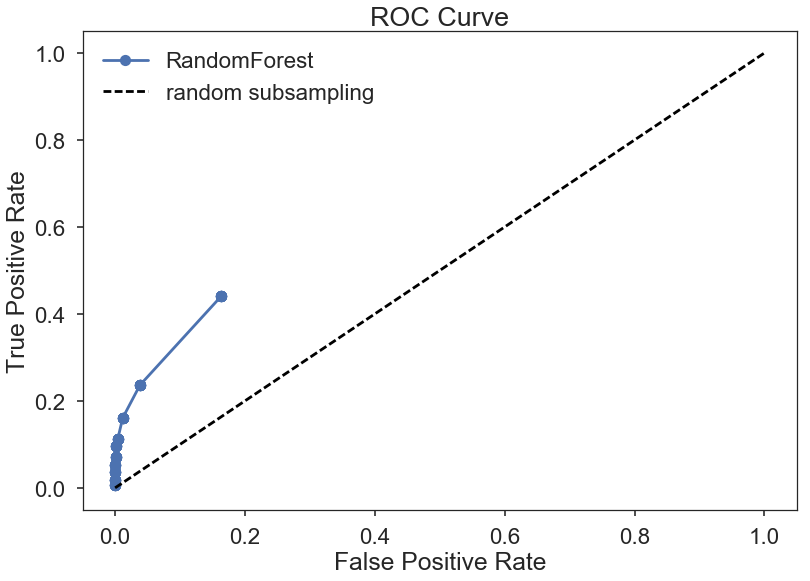

In [32]:
plt.plot(false_positive_rates_RF, true_positive_rates_RF, 
         marker="o", label="RandomForest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0,1], [0,1], 
         color="k", linestyle="dashed", label="random subsampling"
        )

plt.legend(loc="best")
plt.title("ROC Curve")

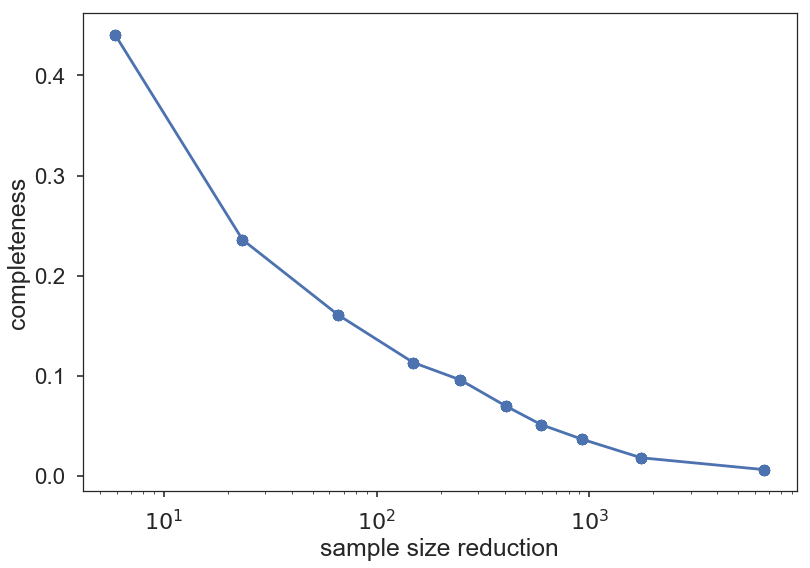

In [33]:
plt.plot(sample_size_reductions_RF, completenesses_RF, marker="o")
plt.xlabel("sample size reduction")
plt.ylabel("completeness")
plt.xscale("log")

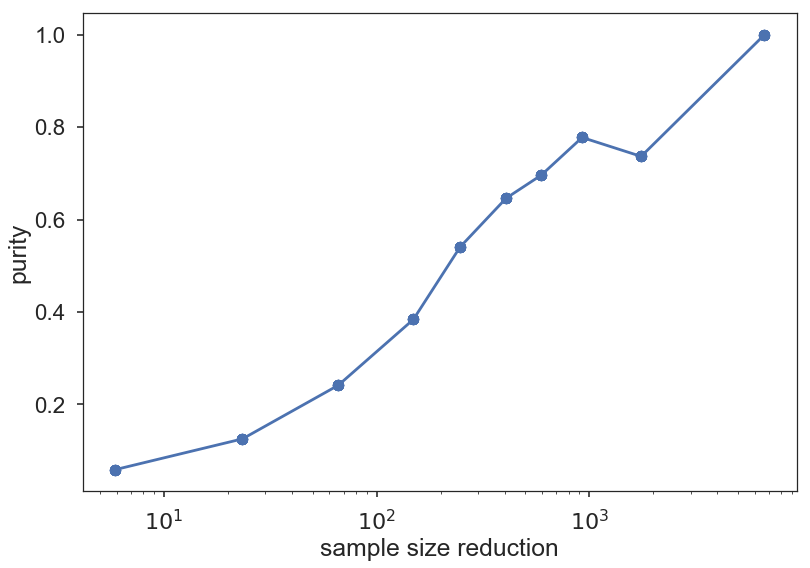

In [34]:
plt.plot(sample_size_reductions_RF, purities_RF, marker="o")
plt.xlabel("sample size reduction")
plt.ylabel("purity")
plt.xscale("log")

## Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression
classifier_LR = LogisticRegression(class_weight="balanced")
classifier_LR = classifier_LR.fit(features_train, np.array(target_train.values.flatten(), dtype=int))

target_prob_LR = classifier_LR.predict_proba(features_test)[:,1]
print("min prob: ", target_prob_LR.min())
print("max prob: ", target_prob_LR.max())

min prob:  0.000600702990742
max prob:  0.992056524354


In [36]:
get_classification_characteristics(target_prob_LR, .01, verbose=True)

completeness:           0.998680738786
purity:                 0.0227054589082
sample_size_reduction:  1.00074985003
true  positive rate:    0.998680738786
false positive rate:    0.999263961726


{'completeness': 0.99868073878627972,
 'false_positive_rate': 0.99926396172600973,
 'purity': 0.022705458908218356,
 'sample_size_reduction': 1.0007498500299941,
 'threshold_prob': 0.01,
 'true_positive_rate': 0.99868073878627972}

In [37]:
threshold_probs = np.linspace(0, 1)[1:-1]
results_LR = [get_classification_characteristics(target_prob_LR, threshold_prob)
              for threshold_prob in threshold_probs]

In [38]:
completenesses_LR         = [result["completeness"] for result in results_LR]
purities_LR               = [result["purity"] for result in results_LR]
sample_size_reductions_LR = [result["sample_size_reduction"] for result in results_LR]
true_positive_rates_LR    = [result["true_positive_rate"] for result in results_LR]
false_positive_rates_LR   = [result["false_positive_rate"] for result in results_LR]

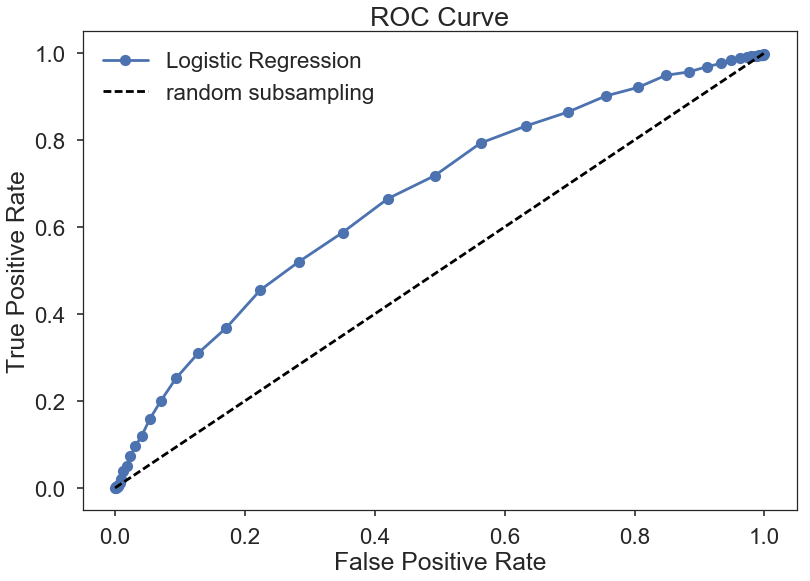

In [39]:
plt.plot(false_positive_rates_LR, true_positive_rates_LR, 
         marker="o", label="Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0,1], [0,1], 
         color="k", linestyle="dashed", label="random subsampling"
        )

plt.legend(loc="best")

plt.title("ROC Curve")

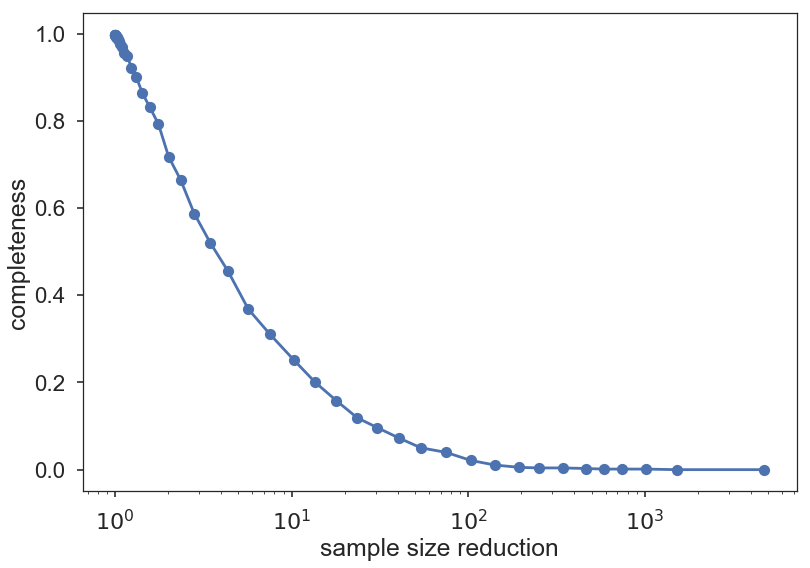

In [40]:
plt.plot(sample_size_reductions_LR, completenesses_LR, marker="o")
plt.xlabel("sample size reduction")
plt.ylabel("completeness")
plt.xscale("log")

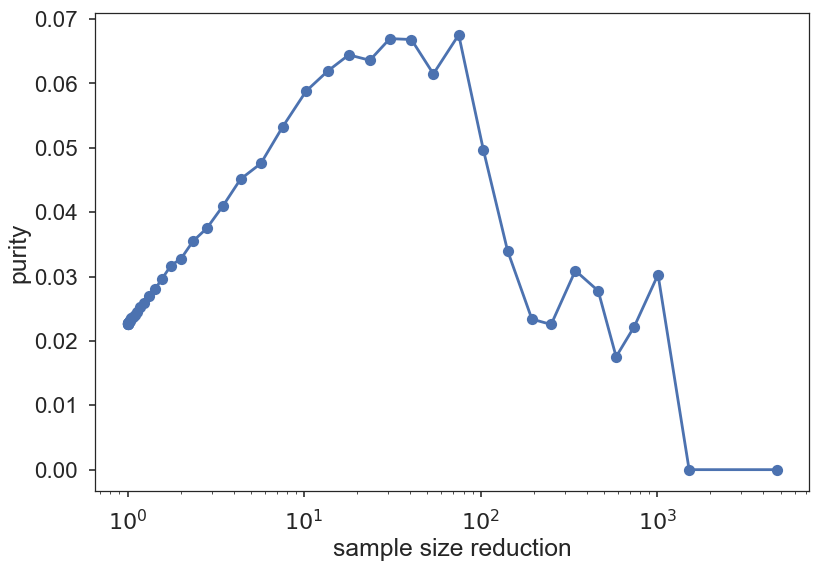

In [41]:
plt.plot(sample_size_reductions_LR, purities_LR, marker="o")
plt.xlabel("sample size reduction")
plt.ylabel("purity")
plt.xscale("log")

## Combined plots

In [42]:
color_LR = "b"
color_RF = "g"

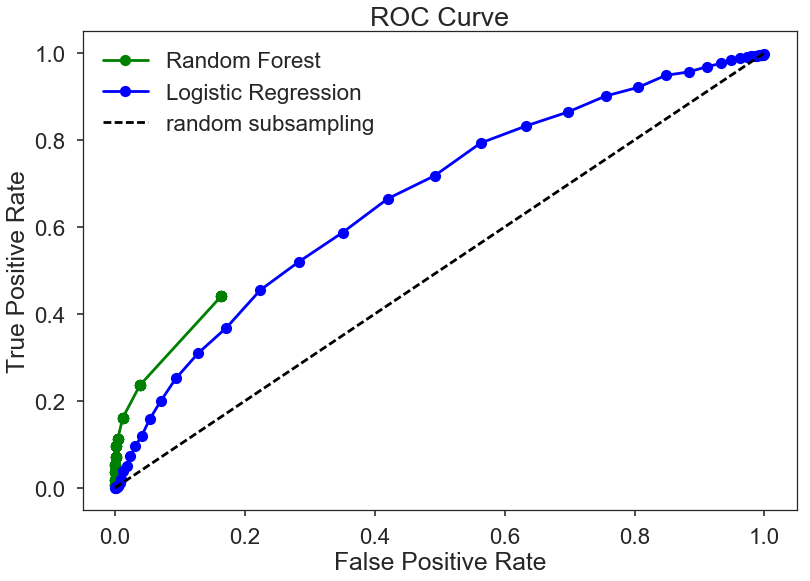

In [43]:
plt.plot(false_positive_rates_RF, true_positive_rates_RF, 
         marker="o", color=color_RF, label="Random Forest")

plt.plot(false_positive_rates_LR, true_positive_rates_LR, 
         marker="o", color=color_LR, label="Logistic Regression")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0,1], [0,1], 
         color="k", linestyle="dashed", label="random subsampling"
        )

plt.legend(loc="best")

plt.title("ROC Curve")

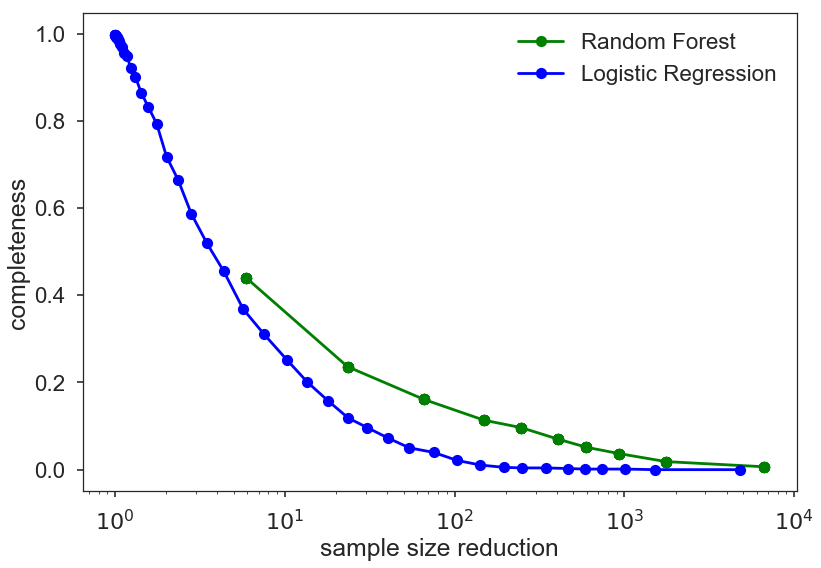

In [44]:
plt.plot(sample_size_reductions_RF, completenesses_RF, 
         marker="o", color=color_RF, label="Random Forest",
        )

plt.plot(sample_size_reductions_LR, completenesses_LR, 
         marker="o", color=color_LR, label="Logistic Regression",
        )
plt.xlabel("sample size reduction")
plt.ylabel("completeness")
plt.xscale("log")

plt.legend(loc="best")

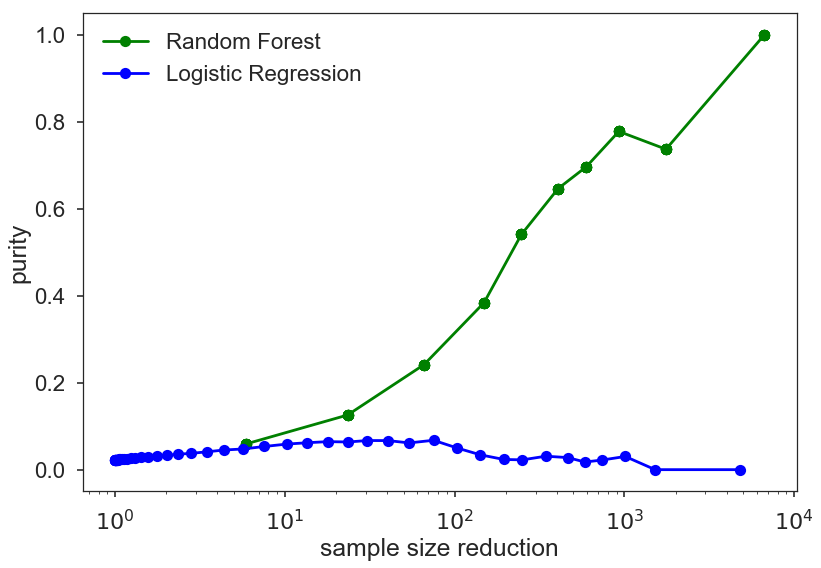

In [45]:
plt.plot(sample_size_reductions_RF, purities_RF, 
         marker="o", color=color_RF, label="Random Forest", 
        )
plt.plot(sample_size_reductions_LR, purities_LR, 
         marker="o", color=color_LR, label="Logistic Regression", 
        )

plt.xlabel("sample size reduction")
plt.ylabel("purity")
plt.xscale("log")

plt.legend(loc="best")

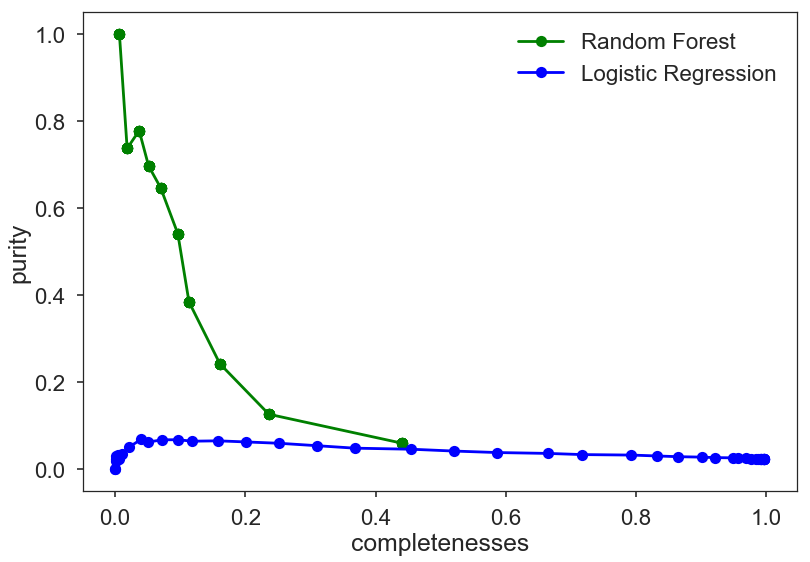

In [46]:
plt.plot(completenesses_RF, purities_RF, 
         marker="o", color=color_RF, label="Random Forest", 
        )
plt.plot(completenesses_LR, purities_LR, 
         marker="o", color=color_LR, label="Logistic Regression", 
        )

plt.xlabel("completenesses")
plt.ylabel("purity")

plt.legend(loc="best")

# Discussion

These results generally behave how I expect.  The key things to notice are: 

1) Random Forest is almost always better, above a sample size reduction of ~6

2) Logistic Regression allows you to reach higher completeness. (Random Forest reaches a probability floor, related to the finite size of the sample set.) 

3) The objects that logistic regression is most confident about (top ~1%) are actually _false positives_